# 📚 Resumen: balancear_dataset_con_augmentation

## 🎯 Objetivo
La función `balancear_dataset_con_augmentation` busca equilibrar un dataset de imágenes de clasificación **aumentando artificialmente las clases minoritarias**. Utiliza técnicas de *data augmentation* para generar nuevas imágenes y alcanzar una cantidad mínima de ejemplos por clase.

---

## ⚙️ Funcionamiento general

1. **Carga de datos**:
   - Lee un archivo `.csv` con los nombres de las imágenes y sus clases.
   - Crea un nuevo directorio de salida para almacenar las imágenes aumentadas y el CSV final.

2. **Verificación inicial**:
   - Revisa valores nulos en el DataFrame.
   - Muestra la cantidad de imágenes por clase antes del balanceo.

3. **Definición de augmentations**:
   - Aplica transformaciones visuales para aumentar la diversidad de datos:
     - `RandomHorizontalFlip`: Volteo horizontal aleatorio.
     - `RandomVerticalFlip`: Volteo vertical aleatorio.
     - `ColorJitter`: Alteraciones de brillo, contraste, saturación y tono.
     - `ToTensor` y `Normalize`: Conversión y normalización de tensores.

4. **Generación de imágenes aumentadas**:
   - Para cada clase:
     - Copia imágenes originales al nuevo directorio.
     - Si la clase tiene menos del mínimo requerido (`min_imagenes_por_clase`):
       - Aplica augmentations sobre imágenes originales seleccionadas aleatoriamente.
       - Guarda las nuevas imágenes con nombres únicos.
       - Registra cada imagen aumentada en el nuevo DataFrame.

5. **Unificación y guardado**:
   - Une las filas originales y aumentadas.
   - Reporta:
     - Distribución final de clases.
     - Cantidad de imágenes originales vs. aumentadas.
   - Guarda un nuevo CSV con el dataset balanceado.

---

## 🖼️ Visualización (opcional)
Se incluye la función `visualizar_imagenes_aumentadas(df, images_dir)` para inspeccionar visualmente algunas imágenes generadas mediante *augmentation*.

---

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path

Valores faltantes en el DataFrame: filename        0
class           0
xmin            0
ymin            0
xmax            0
ymax            0
object_count    0
dtype: int64
Distribución de clases antes del balanceo:
class
f16        41
cougar     37
chinook    35
ah64       34
f15        23
seahawk    19
Name: count, dtype: int64

Procesando clase: cougar - 37 imágenes originales
  Generando 13 imágenes aumentadas para la clase cougar

Procesando clase: seahawk - 19 imágenes originales
  Generando 31 imágenes aumentadas para la clase seahawk

Procesando clase: ah64 - 34 imágenes originales
  Generando 16 imágenes aumentadas para la clase ah64

Procesando clase: f16 - 41 imágenes originales
  Generando 9 imágenes aumentadas para la clase f16

Procesando clase: f15 - 23 imágenes originales
  Generando 27 imágenes aumentadas para la clase f15

Procesando clase: chinook - 35 imágenes originales
  Generando 15 imágenes aumentadas para la clase chinook

Distribución de clases después del ba

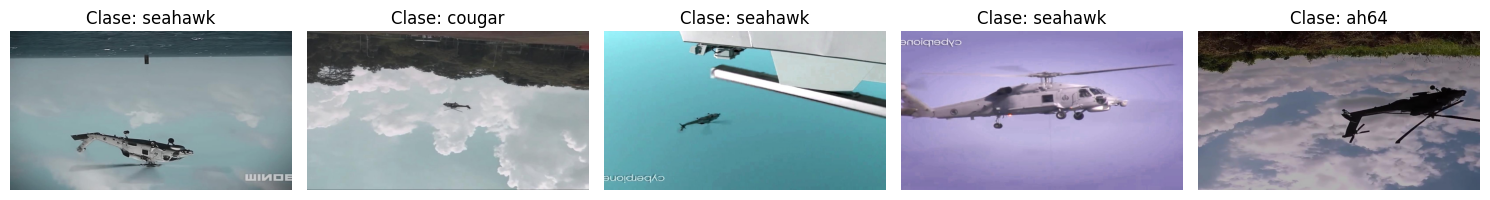

¡Dataset balanceado creado con éxito!


In [ ]:
def balancear_dataset_con_augmentation(csv_path, images_dir, output_dir="dataset_balanceado2", min_imagenes_por_clase=100):
    """
    Balancear el dataset usando técnicas de augmentation para generar imágenes adicionales
    hasta alcanzar el mínimo requerido por clase.
    
    Parámetros:
    -----------
    csv_path : str
        Ruta al archivo CSV con la información de las imágenes
    images_dir : str
        Ruta al directorio que contiene las imágenes originales
    output_dir : str
        Ruta donde se guardarán las imágenes aumentadas y el CSV actualizado
    min_imagenes_por_clase : int
        Número mínimo de imágenes que debería tener cada clase
    """
    # Crear directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Leer el archivo CSV
    df = pd.read_csv(csv_path)
    
    # Verificar valores faltantes
    print(f"Valores faltantes en el DataFrame: {df.isnull().sum()}")
    
    # Contar el número de muestras por clase
    class_counts = df['class'].value_counts()
    print(f"Distribución de clases antes del balanceo:\n{class_counts}")
    
    # Crear el subdirectorio de imágenes en el directorio de salida
    output_images_dir = os.path.join(output_dir, "images")
    os.makedirs(output_images_dir, exist_ok=True)
    
    # Definir transformaciones fuertes para augmentation
    augmentation_transforms = transforms.Compose([
        
        # Aumento 1: Volteo horizontal aleatorio
        # ---------------------------------------
        # Con una probabilidad del 50%, voltea horizontalmente la imagen.
        # Es útil para mejorar la robustez del modelo frente a objetos que pueden aparecer
        # invertidos lateralmente (por ejemplo, un avión mirando hacia la izquierda o derecha).
        transforms.RandomHorizontalFlip(p=0.5),

        # Aumento 2: Volteo vertical aleatorio
        # -------------------------------------
        # Con una probabilidad del 50%, voltea verticalmente la imagen.
        # No siempre se recomienda para tareas donde la orientación vertical importa,
        # pero puede ser útil en contextos donde los objetos pueden estar boca abajo (por ejemplo, aviones, drones y/o helicopteros).
        transforms.RandomVerticalFlip(p=0.5),

        # Aumento 3: Jitter de color
        # --------------------------
        # Aplica perturbaciones aleatorias al brillo, contraste, saturación y tono (hue) de la imagen.
        # Esto permite que el modelo se adapte mejor a distintas condiciones de iluminación y cámaras.
        transforms.ColorJitter(
            brightness=0.3,   # Perturbación del brillo hasta ±30%
            contrast=0.3,     # Perturbación del contraste hasta ±30%
            saturation=0.3,   # Perturbación de la saturación hasta ±30%
            hue=0.1           # Perturbación del tono hasta ±10%
        ),

        # Conversión a tensor
        # -------------------
        # Convierte la imagen de tipo PIL (H x W x C, en rango 0–255) a tensor (C x H x W, en rango 0–1).
        transforms.ToTensor(),

        # Normalización
        # --------------
        # Normaliza cada canal RGB con la media y desviación estándar de ImageNet.
        # Es una práctica común para mejorar la convergencia en el entrenamiento con modelos preentrenados.
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],   # Media de los canales R, G, B
            std=[0.229, 0.224, 0.225]     # Desviación estándar de los canales R, G, B
        )
    ])
    
    # Transformación para recuperar imágenes normalizadas para guardarlas
    denormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                            std=[1/0.229, 1/0.224, 1/0.225])
    ])
    
    # Copiar imágenes originales y generar aumentadas si es necesario
    nuevas_filas = []
    
    for clase in df['class'].unique():
        imagenes_clase = df[df['class'] == clase]
        num_originales = len(imagenes_clase)
        print(f"\nProcesando clase: {clase} - {num_originales} imágenes originales")
        
        # Copiar todas las imágenes originales al directorio de salida
        for _, row in imagenes_clase.iterrows():
            filename = row['filename']
            src_path = os.path.join(images_dir, filename)
            dst_path = os.path.join(output_images_dir, filename)
            
            try:
                # Verificar si el archivo existe
                if os.path.exists(src_path):
                    # Copiar la imagen a la nueva ubicación usando PIL
                    img = Image.open(src_path)
                    img.save(dst_path)
                else:
                    print(f"  Advertencia: No se encontró la imagen original: {src_path}")
            except Exception as e:
                print(f"  Error al procesar la imagen {filename}: {e}")
        
        # Si necesitamos más imágenes para esta clase
        if num_originales < min_imagenes_por_clase:
            num_aumentadas_necesarias = min_imagenes_por_clase - num_originales
            print(f"  Generando {num_aumentadas_necesarias} imágenes aumentadas para la clase {clase}")
            
            # Usar las imágenes originales para generar las aumentadas
            imagenes_para_aumentar = []
            for _, row in imagenes_clase.iterrows():
                try:
                    img_path = os.path.join(images_dir, row['filename'])
                    if os.path.exists(img_path):
                        imagenes_para_aumentar.append((row['filename'], img_path))
                except Exception as e:
                    print(f"  Error al agregar imagen para aumentar: {e}")
            
            if not imagenes_para_aumentar:
                print(f"  Error: No hay imágenes disponibles para aumentar en la clase {clase}")
                continue
                
            # Generar imágenes aumentadas
            for i in range(num_aumentadas_necesarias):
                # Seleccionar una imagen original al azar para aplicar augmentation
                orig_filename, orig_path = imagenes_para_aumentar[i % len(imagenes_para_aumentar)]
                
                try:
                    # Abrir la imagen original
                    img = Image.open(orig_path).convert('RGB')
                    
                    # Aplicar transformaciones de augmentation
                    augmented_tensor = augmentation_transforms(img)
                    
                    # Desnormalizar para guardar como imagen
                    augmented_tensor = denormalize(augmented_tensor)
                    
                    # Generar nombre para la imagen aumentada
                    base_name = Path(orig_filename).stem
                    aug_filename = f"{base_name}_aug_{i+1}.jpg"
                    aug_path = os.path.join(output_images_dir, aug_filename)
                    
                    # Guardar la imagen aumentada
                    save_image(augmented_tensor, aug_path)
                    
                    # Agregar la información de esta imagen al nuevo DataFrame
                    nuevas_filas.append({
                        'filename': aug_filename,
                        'class': clase,
                        'type': 'augmented'
                    })
                    
                except Exception as e:
                    print(f"  Error al aumentar la imagen {orig_filename}: {e}")
        
        else:
            print(f"  La clase {clase} ya tiene suficientes imágenes ({num_originales} >= {min_imagenes_por_clase})")
    
    # Agregar columna 'type' al DataFrame original para indicar imágenes originales
    df['type'] = 'original'
    
    # Crear DataFrame con las nuevas imágenes aumentadas
    if nuevas_filas:
        df_aumentado = pd.DataFrame(nuevas_filas)
        
        # Combinar el DataFrame original con las nuevas filas
        df_final = pd.concat([df, df_aumentado], ignore_index=True)
    else:
        df_final = df
    
    # Verificar el balance final
    final_class_counts = df_final['class'].value_counts()
    print(f"\nDistribución de clases después del balanceo:\n{final_class_counts}")
    
    # Verificar por tipo (original vs aumentado)
    type_counts = df_final.groupby(['class', 'type']).size().unstack(fill_value=0)
    print(f"\nDistribución por tipo de imagen:\n{type_counts}")
    
    # Guardar el DataFrame actualizado como CSV
    csv_output_path = os.path.join(output_dir, "train_balanceado.csv")
    df_final.to_csv(csv_output_path, index=False)
    print(f"\nDataset balanceado guardado en: {csv_output_path}")
    
    return df_final, output_images_dir

# Visualizar algunas imágenes aumentadas (opcional)
def visualizar_imagenes_aumentadas(df, images_dir, num_imagenes=5):
    """
    Visualiza algunas imágenes aumentadas para verificar la calidad.
    """
    if 'type' not in df.columns:
        print("El DataFrame no contiene la columna 'type'")
        return
    
    # Filtrar solo las imágenes aumentadas
    df_aug = df[df['type'] == 'augmented']
    
    if len(df_aug) == 0:
        print("No hay imágenes aumentadas para visualizar")
        return
    
    # Seleccionar imágenes aleatorias para visualizar
    sample_rows = df_aug.sample(min(num_imagenes, len(df_aug)))
    
    # Crear la visualización
    fig, axes = plt.subplots(1, len(sample_rows), figsize=(15, 4))
    
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img_path = os.path.join(images_dir, row['filename'])
        try:
            img = Image.open(img_path)
            if len(sample_rows) > 1:
                axes[i].imshow(img)
                axes[i].set_title(f"Clase: {row['class']}")
                axes[i].axis('off')
            else:
                axes.imshow(img)
                axes.set_title(f"Clase: {row['class']}")
                axes.axis('off')
        except Exception as e:
            print(f"Error al visualizar {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    csv_path = '../Datos/train.csv'  # Actualiza con tu ruta real
    images_dir = '../Datos/images/images'  # Actualiza con tu ruta real
    
    df_balanceado, output_images_dir = balancear_dataset_con_augmentation(
        csv_path, 
        images_dir, 
        min_imagenes_por_clase=50  # Asegura al menos 100 imágenes por clase
    )
    
    # Visualizar algunas imágenes aumentadas
    visualizar_imagenes_aumentadas(df_balanceado, output_images_dir)
    
    print("¡Dataset balanceado creado con éxito!")